# Section 3.1.2 Filtering Outliers

In [106]:
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [107]:
# Load water market data from CSV files
water_market_data = pd.read_csv('../../data/ALL_water_share_trading.csv', parse_dates=['Application Creation Date'])


water_market_data['Create_date'] = pd.to_datetime(water_market_data['Application Creation Date'], format='%d/%m/%Y')  # Specify the format if needed
#water_market_data = water_market_data.dropna()

# Filter to only keep trades that went through (other statuses are "Rejected", "Expired", "Refused")
water_market_data = water_market_data[water_market_data['Status'] == 'Recorded']

water_market_data = water_market_data[water_market_data['Reliability'] == 'High']

water_market_data = water_market_data[water_market_data['Price Per ML ($)'] > 0]


# Remove Outliers
Q1 = water_market_data['Price Per ML ($)'].quantile(0.25)
Q3 = water_market_data['Price Per ML ($)'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR +5000
print(lower_bound)
print(upper_bound)

clean_data = water_market_data[(water_market_data['Price Per ML ($)'] >= lower_bound) & (water_market_data['Price Per ML ($)'] <= upper_bound)]

# Filter out rows where the status is 'Rejected'
#filtered_data = clean_data[clean_data['Status'] != 'Rejected']








/var/folders/d9/x_bnq71n58lbk4_znq_twz6h0000gn/T/ipykernel_73273/1320711134.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  water_market_data = pd.read_csv('../../data/ALL_water_share_trading.csv', parse_dates=['Application Creation Date'])


-1627.375
12245.625


In [108]:
offset = '1095D'

Q1 = water_market_data.set_index('Create_date').sort_index()['Price Per ML ($)'].dropna().rolling(offset).quantile(0.25)
Q3 = water_market_data.set_index('Create_date').sort_index()['Price Per ML ($)'].dropna().rolling(offset).quantile(0.75)
Q2 = water_market_data.set_index('Create_date').sort_index()['Price Per ML ($)'].dropna().rolling(offset).quantile(0.5)

IQR = Q3 - Q1

# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR*5
upper_bound = Q3 + 1.5 * IQR*5

Create Filtered and clean data sets of water market data

In [109]:
# Filtered data is removal of outliers via IQR method
filtered_data = water_market_data.sort_values('Create_date')[(water_market_data.sort_values('Create_date')['Price Per ML ($)'] >= lower_bound.values) & (water_market_data.sort_values('Create_date')['Price Per ML ($)'] <= upper_bound.values)]
filtered_data.to_csv('filtered_data.csv')

#Clean data is removal of rejected and low reliability trades, without removing outliers
clean_data.to_csv('clean_data.csv')



Text(0, 0.5, 'Price')

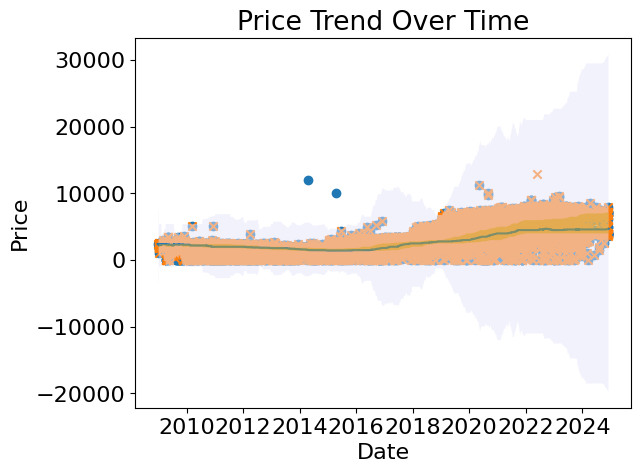

In [110]:
#plt.plot(lower_bound.index, lower_bound.values)
#plt.plot(upper_bound.index, upper_bound.values)
plt.plot(Q2.index, Q2.values)

plt.scatter(clean_data['Create_date'], clean_data['Price Per ML ($)'])
plt.scatter(filtered_data['Create_date'], filtered_data['Price Per ML ($)'], marker='x')


plt.fill_between(lower_bound.index, lower_bound.values, upper_bound.values, fc='lavender', zorder=1, alpha=0.5, label="Outlier Range")
plt.fill_between(lower_bound.index, Q1.values, Q3.values, fc='goldenrod', zorder=2, alpha=0.5, label="IQR")

plt.title('Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Price')

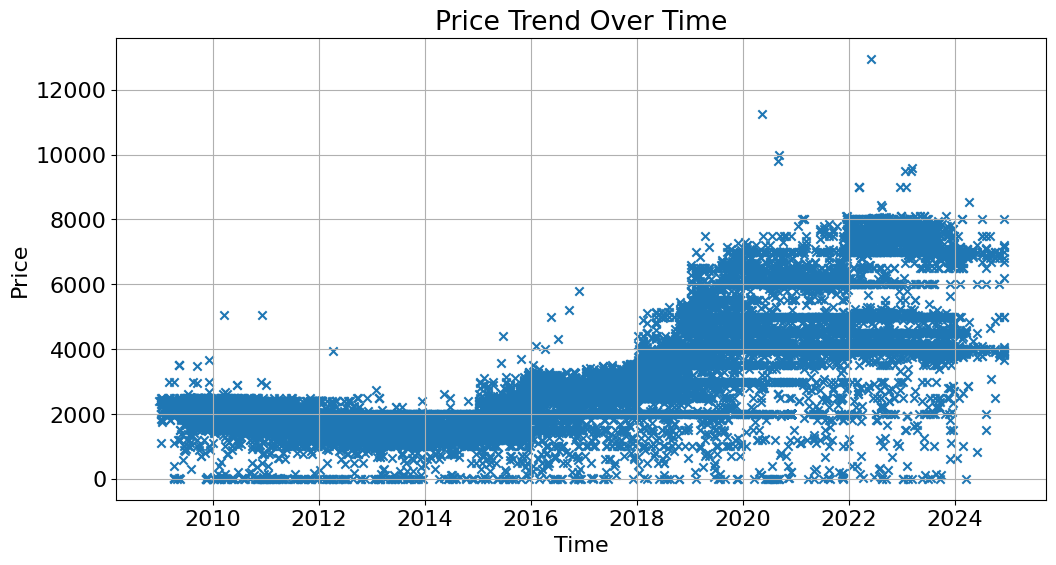

In [111]:
# Visualize the data of price vs time using a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(filtered_data['Create_date'], filtered_data['Price Per ML ($)'], marker='x')
plt.title('Price Trend Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()


/var/folders/d9/x_bnq71n58lbk4_znq_twz6h0000gn/T/ipykernel_73273/3876769046.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_zones))


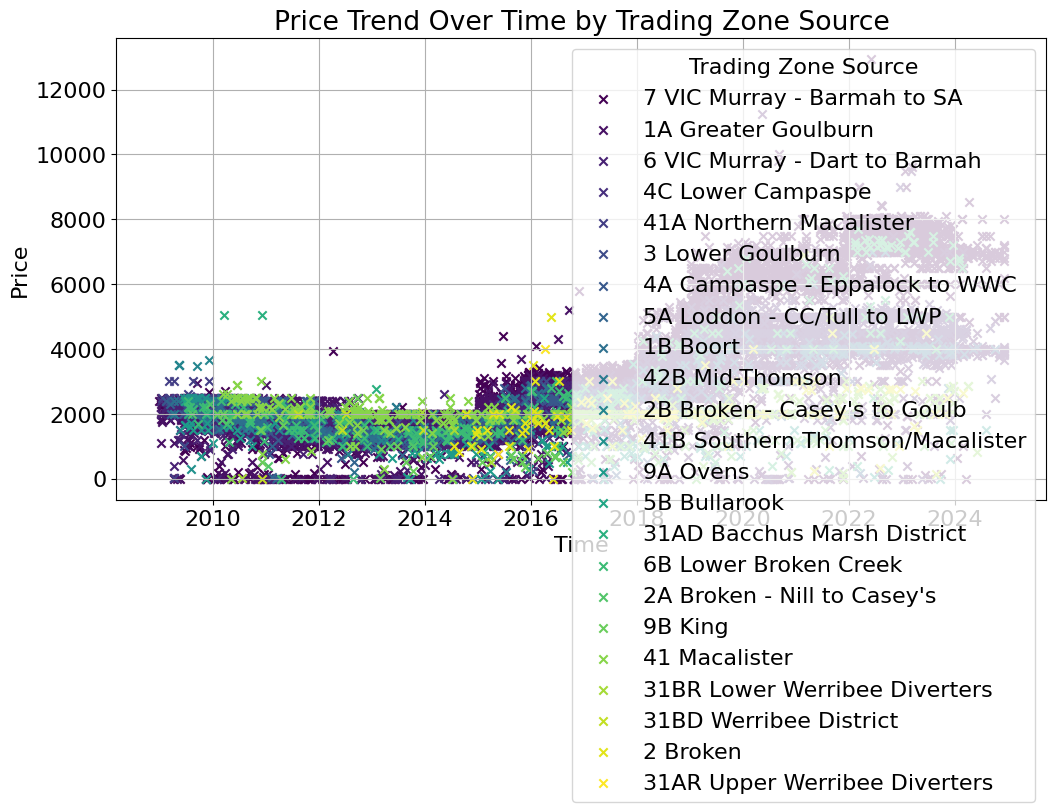

In [112]:
# Color code the data in terms of Trading Zone Source

# Create a color map for unique Trading Zone Source values
unique_zones = filtered_data['Trading Zone Source'].unique()
colors = plt.cm.get_cmap('viridis', len(unique_zones))

# Map each Trading Zone Source to a color
zone_to_color = {zone: colors(i) for i, zone in enumerate(unique_zones)}

# Plot with color coding
plt.figure(figsize=(12, 6))
for zone, color in zone_to_color.items():
    zone_data = filtered_data[filtered_data['Trading Zone Source'] == zone]
    plt.scatter(zone_data['Create_date'], zone_data['Price Per ML ($)'], color=color, label=zone, marker='x')

plt.title('Price Trend Over Time by Trading Zone Source')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.legend(title='Trading Zone Source')
plt.show()



/var/folders/d9/x_bnq71n58lbk4_znq_twz6h0000gn/T/ipykernel_73273/380416312.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_zones))


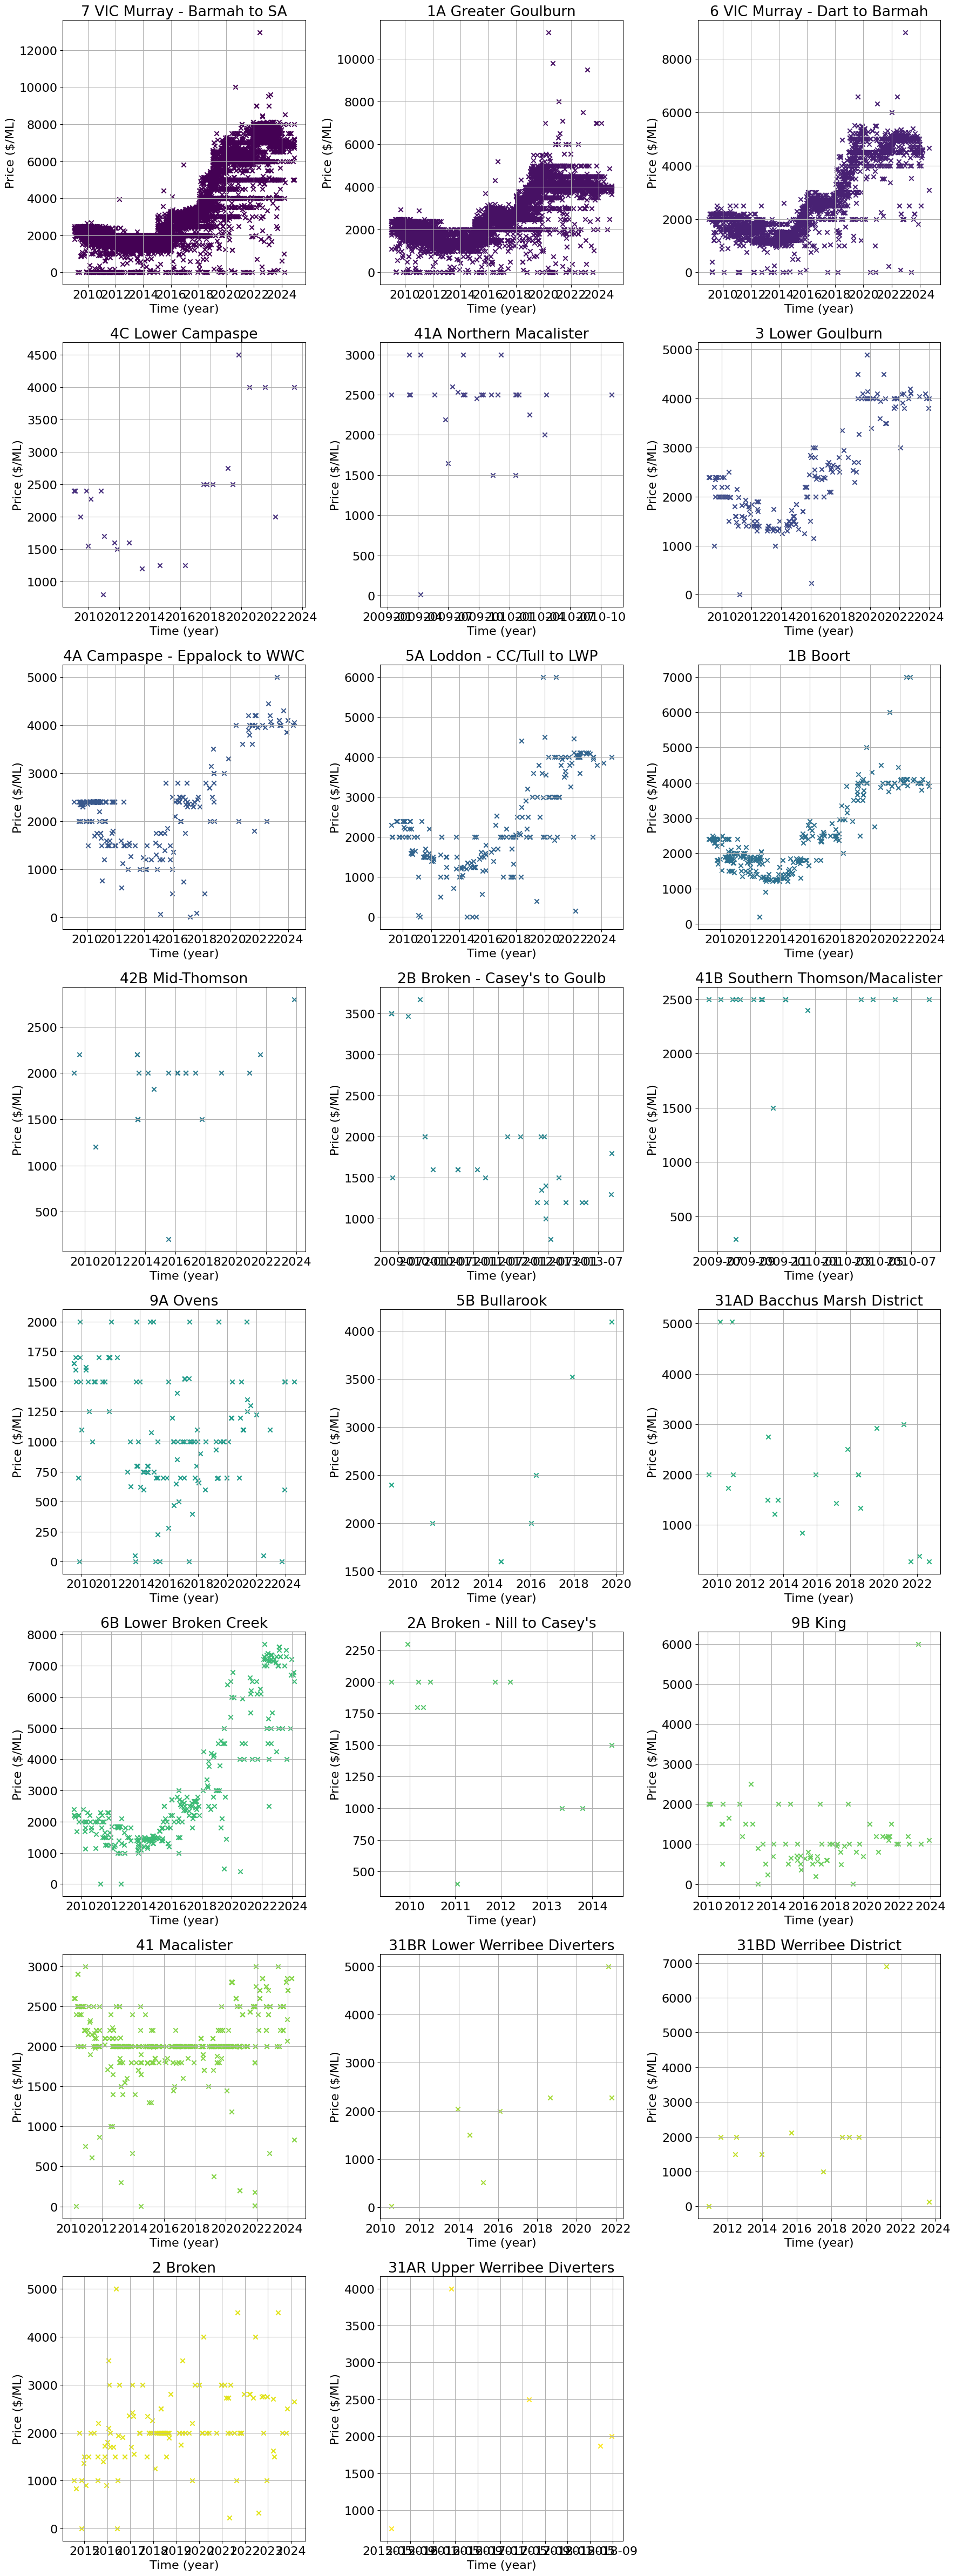

In [113]:
import math
# Create a color map for unique Trading Zone Source values
unique_zones = filtered_data['Trading Zone Source'].unique()
colors = plt.cm.get_cmap('viridis', len(unique_zones))

# Map each Trading Zone Source to a color
zone_to_color = {zone: colors(i) for i, zone in enumerate(unique_zones)}

# Determine the number of rows needed for the subplot grid
num_zones = len(unique_zones)
num_columns = 3
num_rows = math.ceil(num_zones / num_columns)

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, 6 * num_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each Trading Zone Source in its subplot
for i, zone in enumerate(unique_zones):
    zone_data = filtered_data[filtered_data['Trading Zone Source'] == zone]
    ax = axes[i]
    ax.scatter(zone_data['Create_date'], zone_data['Price Per ML ($)'], color=colors(i), marker='x')
    ax.set_title(f'{zone}')
    ax.set_xlabel('Time (year)')
    ax.set_ylabel('Price ($/ML)')
    ax.grid(True)


# Hide any unused axes if there are any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

/var/folders/d9/x_bnq71n58lbk4_znq_twz6h0000gn/T/ipykernel_73273/925088615.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('plasma', 10)


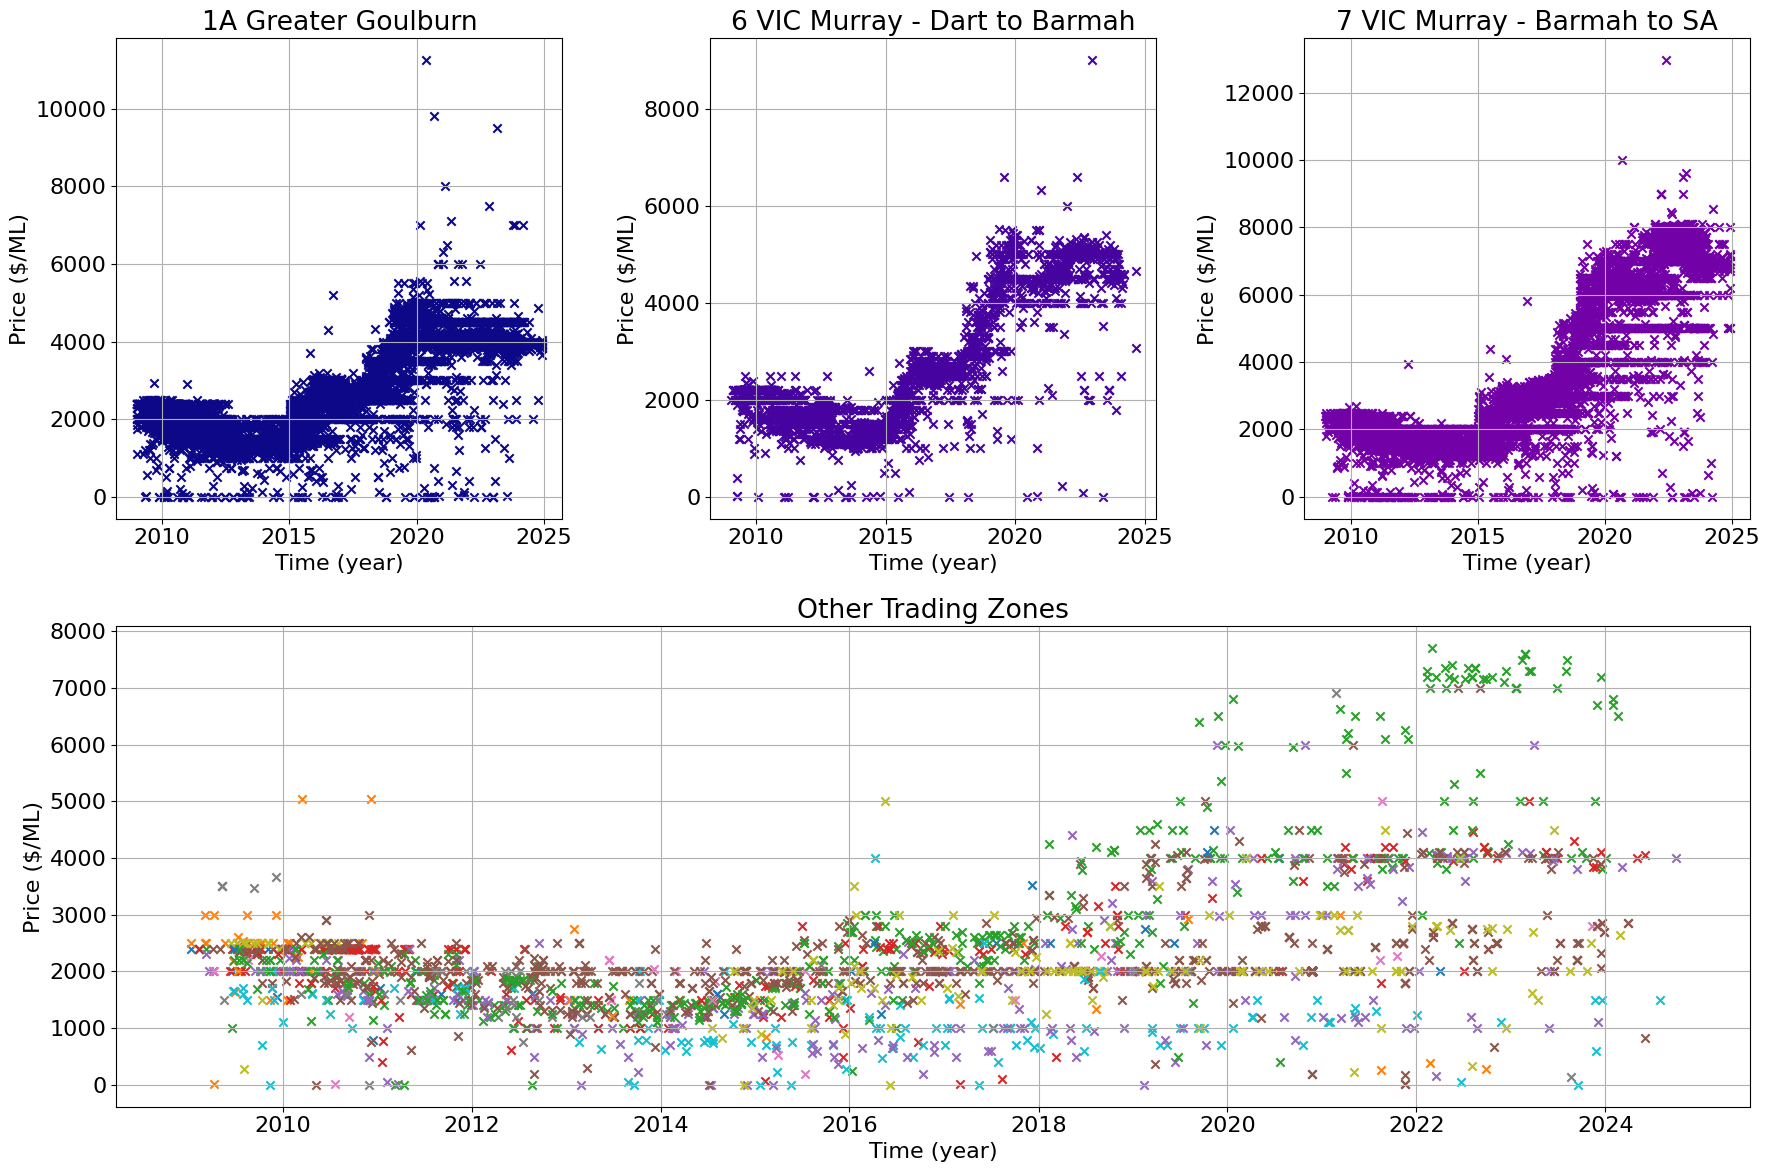

In [114]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
# Create a color map for unique Trading Zone Source values
unique_zones = filtered_data['Trading Zone Source'].unique()
colors = plt.cm.get_cmap('plasma', 10)
import matplotlib.dates as mdates


# Map each Trading Zone Source to a color
zone_to_color = {zone: colors(i) for i, zone in enumerate(unique_zones)}

# Specific zones to be plotted on the top row
specific_zones = ['1A Greater Goulburn', '6 VIC Murray - Dart to Barmah', '7 VIC Murray - Barmah to SA']

# Create subplots: 2 rows, with the top row having 3 columns and the bottom row 1 column
fig, axes = plt.subplots(2, 3, figsize=(18, 12), gridspec_kw={'height_ratios': [1, 1]})
axes[1, 1].axis('off')  # Turn off the middle and right plots on the second row
axes[1, 2].axis('off')
axes[1, 0].axis('off')

# Plot specific zones in the top row
for i, zone in enumerate(specific_zones):
    zone_data = filtered_data[filtered_data['Trading Zone Source'] == zone]
    axes[0, i].scatter(zone_data['Create_date'], zone_data['Price Per ML ($)'], color=colors(i), marker='x')
    axes[0, i].set_title(f'{zone}')
    axes[0, i].set_xlabel('Time (year)')
    axes[0, i].set_ylabel('Price ($/ML)')
    axes[0, i].grid(True)
    axes[0, i].xaxis.set_major_locator(mdates.YearLocator(5)) 
    

# Plot all other zones in a wide row below
other_zones = [z for z in unique_zones if z not in specific_zones]
ax_big = fig.add_subplot(2, 1, 2)  # Create a big subplot for the second row
for zone in other_zones:
    zone_data = filtered_data[filtered_data['Trading Zone Source'] == zone]
    ax_big.scatter(zone_data['Create_date'], zone_data['Price Per ML ($)'], label=zone, marker='x')
ax_big.set_title('Other Trading Zones')
ax_big.set_xlabel('Time (year)')
ax_big.set_ylabel('Price ($/ML)')
ax_big.grid(True)


# Adjust layout
plt.tight_layout()
plt.show()

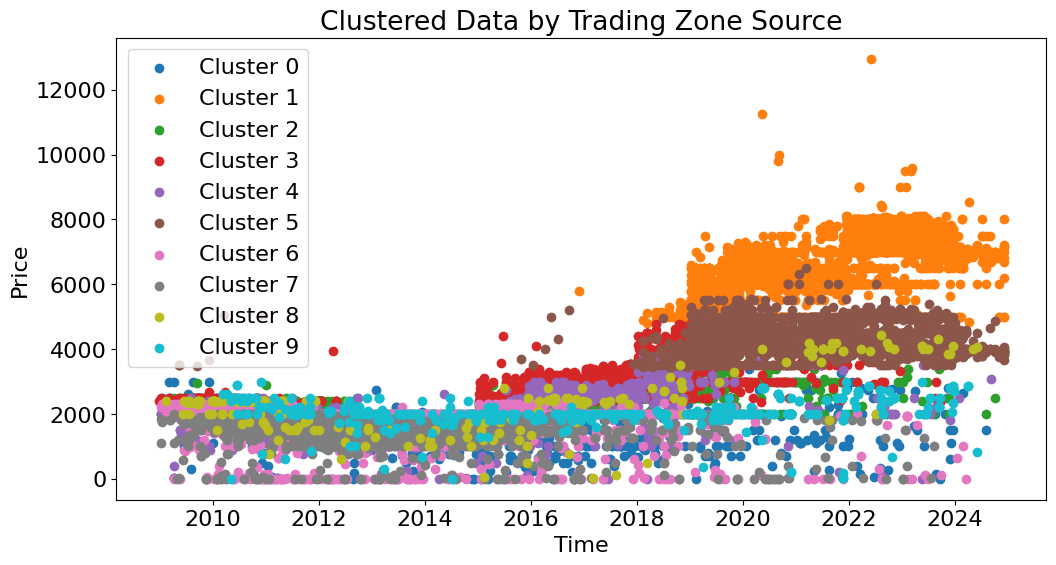

In [115]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Assuming 'Trading Zone Source' is categorical and 'Price Per ML ($)' is numerical
features = ['Trading Zone Source', 'Price Per ML ($)']
data_for_clustering = filtered_data[features]

# Preprocessing for numerical data: scaling
scaler = StandardScaler()

# Preprocessing for categorical data: one-hot encoding
categorical_features = ['Trading Zone Source']
one_hot = OneHotEncoder()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, ['Price Per ML ($)']),
        ('cat', one_hot, categorical_features)
    ])

# Define the KMeans clustering model
kmeans = KMeans(n_clusters=10, random_state=42)

# Create a pipeline that executes the preprocessor and the clustering model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('clusterer', kmeans)])

# Fit the pipeline to the data
pipeline.fit(data_for_clustering)

# Get cluster labels
cluster_labels = pipeline['clusterer'].labels_

# Add cluster labels to the original dataframe
filtered_data['Cluster'] = cluster_labels

# Visualize the clusters
plt.figure(figsize=(12, 6))
for cluster in np.unique(cluster_labels):
    cluster_data = filtered_data[filtered_data['Cluster'] == cluster]
    plt.scatter(cluster_data['Create_date'], cluster_data['Price Per ML ($)'], label=f'Cluster {cluster}')
plt.title('Clustered Data by Trading Zone Source')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()